In [1]:
import pandas as pd
import geopandas as gpd
import requests

In [2]:
# get all schools 
URL = 'https://ws.schools.nyc/schooldata/GetSchools?search=&borough='
r = requests.get(url = URL, verify=False)
data = r.json() 
df = pd.DataFrame(data)
df.sample(2)

C:\Users\zhi\.conda\envs\class\lib\site-packages\urllib3\connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ws.schools.nyc'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


,locationCode,type,boroughName,boroughCode,name,phoneNumber,primaryAddressLine,zip,grades,stateCode,x,y,profile,neighborhood,district,distance,dataflag
616,M063,DOE,Manhattan,M,The STAR Academy - P.S.63,212-674-3180,121 EAST 3 STREET,10009,"PK,0K,01,02,03,04,05,SE",NY,-8236107.66820000,4971781.19860000,,East Village ...,01,,L
1237,Q337,Charter,Queens,Q,Success Academy Charter School - Rosedale,347-514-7060,147-65 249 Street,11422,"0K,01,02,03,04,06,07,08,SE",NY,-8208564.88850000,4961705.65680000,,Rosedale ...,29,,L


In [3]:
# convert dataframe to geopandas with crs (102100) and reproject to 4326
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['x'], df['y']), crs = 102100).to_crs(4326)

In [4]:
# get all points within the two zones
onehrtrans = gpd.read_file('../processed/nycbg1hrtrans.gpkg').to_crs(4326).dissolve()
sewershed = gpd.read_file('../processed/sewershed-tracts.gpkg').to_crs(4326).dissolve()

schools_within_onehrtrans = gdf[gdf.intersects(onehrtrans.iloc[0]['geometry'])] # use shaply object instead of dataframe
schools_within_sewershed = gdf[gdf.intersects(sewershed.iloc[0]['geometry'])]

PROJ: proj_create_from_database: Cannot find proj.db


<Axes: >

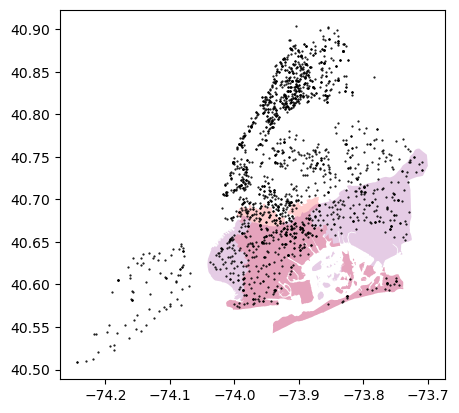

In [5]:
ax = onehrtrans.plot(color='red', alpha = 0.2)
sewershed.plot(color='purple', alpha = 0.2, ax = ax)
gdf.plot(markersize = 0.3, ax = ax, color = 'black')

In [6]:
len(schools_within_onehrtrans),len(schools_within_sewershed)

(370, 541)

In [7]:
# process demograph data 
# https://infohub.nyced.org/docs/default-source/default-document-library/demographic-snapshot-2019-20-to-2023-24-public.xlsx
schools_demographics = pd.read_excel('./data/demographic-snapshot-2019-20-to-2023-24-public.xlsx', sheet_name = 'School')
schools_demographics.sample(2)

,DBN,School Name,Year,Total Enrollment,Grade 3K,Grade PK (Half Day & Full Day),Grade K,Grade 1,Grade 2,Grade 3,...,% White,# Missing Race/Ethnicity Data,% Missing Race/Ethnicity Data,# Students with Disabilities,% Students with Disabilities,# English Language Learners,% English Language Learners,# Poverty,% Poverty,Economic Need Index
5908,25Q425,John Bowne High School,2019-20,3432,0,0,0,0,0,0,...,0.052448,56,0.016317,525,0.152972,619,0.180361,2588,0.754079,0.772903
120,01M696,Bard High School Early College,2019-20,613,0,0,0,0,0,0,...,0.376835,0,0.000000,65,0.106036,0,0.000000,259,0.422512,0.425246


In [8]:
# convert DBN to locationCode
schools_demographics['locationCode'] = schools_demographics['DBN'].str.slice(2)

# select the latest year
latest_year = '2023-24'
latest_year_schools_demographics = schools_demographics[schools_demographics['Year'] == latest_year].copy()

In [9]:
# filter down 

# 365  / 629, doesn't include NYCEEC (early edu centers , pre-k) and charters 
schools_within_onehrtrans_demographics = latest_year_schools_demographics[
    latest_year_schools_demographics['locationCode'].isin(schools_within_onehrtrans['locationCode'])
]

# 532 / 979
schools_within_sewershed_demographics = latest_year_schools_demographics[
    latest_year_schools_demographics['locationCode'].isin(schools_within_sewershed['locationCode'])
]

In [10]:
# missing schools 
schools_within_onehrtrans[
    ~schools_within_onehrtrans['locationCode'].isin(schools_within_onehrtrans_demographics['locationCode'])]['type'].value_counts()

type
Charter    4
DOE        2
Name: count, dtype: int64

In [11]:
# SUM! things

In [12]:
columns = [
    'Total Enrollment',
    'Grade 3K',
    'Grade PK (Half Day & Full Day)',
    'Grade K',
    'Grade 1',
    'Grade 2',
    'Grade 3',
    'Grade 4',
    'Grade 5',
    'Grade 6',
    'Grade 7',
    'Grade 8',
    'Grade 9',
    'Grade 10',
    'Grade 11',
    'Grade 12',
    '# Female',
    '# Male',
    '# Neither Female nor Male',
    '# Asian',
    '# Black',
    '# Hispanic',
    '# Multi-Racial',
    '# Native American',
    '# White',
    '# Missing Race/Ethnicity Data',
    '# Students with Disabilities',
    '# English Language Learners'
]

t1 = pd.DataFrame(schools_within_onehrtrans_demographics[columns].sum()).transpose()
t2 = pd.DataFrame(schools_within_sewershed_demographics[columns].sum()).transpose()

pd.concat([t1,t2])

,Total Enrollment,Grade 3K,Grade PK (Half Day & Full Day),Grade K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,...,# Neither Female nor Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners
0,185868.0,1555.0,4883.0,12843.0,13048.0,13151.0,12955.0,13019.0,12742.0,13939.0,...,30.0,25963.0,75335.0,45183.0,3236.0,2071.0,33166.0,914.0,38987.0,25056.0
0,306838.0,2219.0,7240.0,22818.0,23285.0,23787.0,23367.0,23455.0,23544.0,23570.0,...,28.0,65623.0,95094.0,88695.0,4411.0,6630.0,45134.0,1251.0,61075.0,50590.0


In [13]:
pd.concat([t1,t2]).to_csv('schools_demographic.csv', index = False)